In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import datetime as dt

In [2]:
#Read daily maximum wind gusts at each station, created by resample_daily_max.py

dmax_2p2km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km.csv")
dmax_12km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_12km.csv")
dmax_obs = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_obs.csv")
dmax_bdsd = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_bdsd.csv")

dmax_2p2km_point = dmax_2p2km_point.set_index(pd.to_datetime(dmax_2p2km_point.time))
dmax_12km_point = dmax_12km_point.set_index(pd.to_datetime(dmax_12km_point.time))
dmax_obs = dmax_obs.set_index(pd.to_datetime(dmax_obs.time))
dmax_bdsd = dmax_bdsd.set_index(pd.to_datetime(dmax_bdsd.time))

In [3]:
#Suspect gusts to drop - observations
obs_times = pd.to_datetime(dmax_obs.time)
dmax_obs.loc[(obs_times.dt.month == 12) & (obs_times.dt.year == 2010) & (dmax_obs.stn_id==55325) & (dmax_obs.gust >= 25),"gust"] = np.nan
dmax_obs.loc[dmax_obs.gust>=129, "gust"] = np.nan 


In [4]:
#Take the domain maximum for each day
dmax_2p2km_all = dmax_2p2km_point.sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_all = dmax_12km_point.sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_all = dmax_obs.dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_bdsd_all = dmax_bdsd.sort_values("bdsd").drop_duplicates("dt_floor_1D",keep="last").sort_index()

In [5]:
#Take the domain maximum for each day using daily maximum observations at each station with lightning
dmax_2p2km_conv = dmax_2p2km_point.query("n_lightning_fl>=1").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_conv = dmax_12km_point.query("n_lightning_fl>=1").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_conv = dmax_obs.query("Lightning_observed_daily>=1").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()

#Take the domain maximum for each day using daily maximum observations at each station without lightning
dmax_2p2km_nonconv = dmax_2p2km_point.query("n_lightning_fl==0").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_nonconv = dmax_12km_point.query("n_lightning_fl==0").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_nonconv = dmax_obs.query("Lightning_observed_daily==0").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()


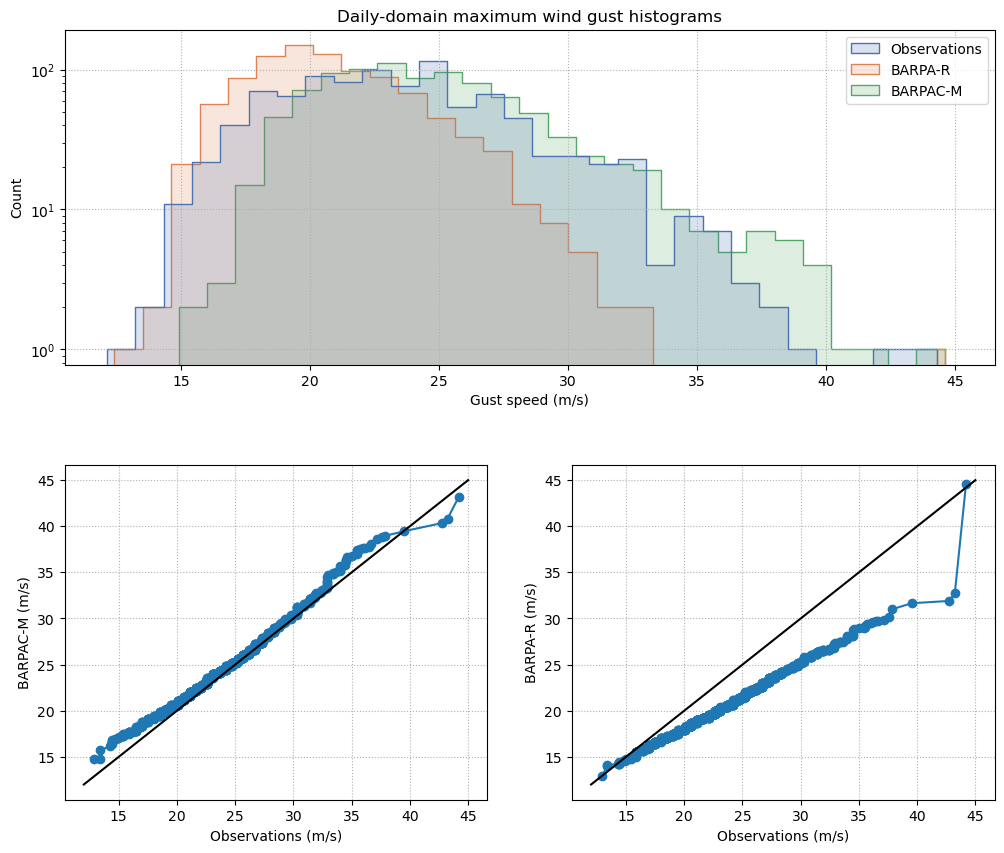

In [12]:
#Use seaborn to plot a stepped histoigram for daily-domain maximum data as a comparison
# between model and observations

plt.figure(figsize=[12,10])

plt.subplot2grid((2,2),(0,0),1,2)

values_2p2km = dmax_2p2km_all["wg10_2p2km_point"].values
values_12km = dmax_12km_all["wg10_12km_point"].values
values_obs = dmax_obs_all["gust"].values
temp_df = pd.DataFrame({"Observations":values_obs, "BARPA-R":values_12km, "BARPAC-M":values_2p2km})

hist = sns.histplot(data=temp_df, bins=30, binrange=[12,45], 
             log_scale=[False,True], multiple="dodge", shrink=0.8, stat="count",common_norm=False,
             element="step",alpha=0.2,legend=True,palette="deep")

plt.gca().grid(ls=":")
plt.xlabel("Gust speed (m/s)")
plt.title("Daily-domain maximum wind gust histograms")

#Use pyplot to plot a rank-size wind gust distribution

plt.subplot2grid((2,2),(1,0),1,1)
p=1000
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_2p2km,np.linspace(0,100,p)),ls="-",marker="o")
plt.plot([12,45],[12,45],color="k")
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.xlabel("Observations (m/s)")

plt.subplot2grid((2,2),(1,1),1,1)
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_12km,np.linspace(0,100,p)),ls="-",marker="o")
plt.plot([12,45],[12,45],color="k")
plt.gca().grid(ls=":")
plt.ylabel("BARPA-R (m/s)")
plt.xlabel("Observations (m/s)")

# plt.plot(np.flip(np.sort(values_obs)),label="Observations",color="tab:blue",marker="o",ms=4)
# plt.plot(np.flip(np.sort(values_12km)),label="BARPA-R",color="tab:orange",marker="o",ms=4)
# plt.plot(np.flip(np.sort(values_2p2km)),label="BARPAC-M",color="tab:green",marker="o",ms=4)

# plt.xscale("symlog")
# #plt.ylim([0,45])
# plt.gca().grid(ls=":")
# plt.legend()
# plt.xlabel("Rank")
# plt.title("Rank-size daily-domain maximum wind gust distribution")
# plt.ylabel("Gust speed (m/s)")



plt.subplots_adjust(hspace=0.3)

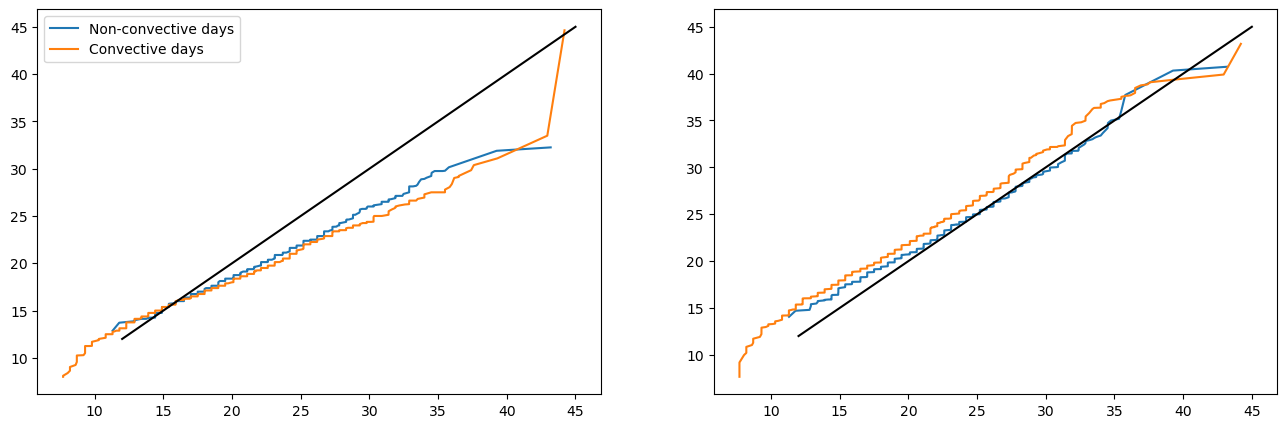

In [13]:
#Plot a QQ plot for domain-daily maximum wind gusts between model(s) and observations, separately for days with and without lightning

plt.figure(figsize=[16,5])

values_obs_all = dmax_obs_all["gust"].values
values_2p2km_all = dmax_2p2km_all["wg10_2p2km_point"].values
values_12km_all = dmax_12km_all["wg10_12km_point"].values
values_obs_conv = dmax_obs_conv["gust"].values
values_2p2km_conv = dmax_2p2km_conv["wg10_2p2km_point"].values
values_12km_conv = dmax_12km_conv["wg10_12km_point"].values
values_obs_nonconv = dmax_obs_nonconv["gust"].values
values_2p2km_nonconv = dmax_2p2km_nonconv["wg10_2p2km_point"].values
values_12km_nonconv = dmax_12km_nonconv["wg10_12km_point"].values

p=1000

plt.subplot(1,2,1)
#plt.plot(np.percentile(values_obs_all,np.linspace(0,100,p)),np.percentile(values_12km_all,np.linspace(0,100,p)),ls="-",label="All gusts")
plt.plot(np.percentile(values_obs_nonconv,np.linspace(0,100,p)),np.percentile(values_12km_nonconv,np.linspace(0,100,p)),ls="-",label="Non-convective days")
plt.plot(np.percentile(values_obs_conv,np.linspace(0,100,p)),np.percentile(values_12km_conv,np.linspace(0,100,p)),ls="-",label="Convective days")
plt.legend()
plt.plot([12,45],[12,45],color="k")

plt.subplot(1,2,2)
#plt.plot(np.percentile(values_obs_all,np.linspace(0,100,p)),np.percentile(values_2p2km_all,np.linspace(0,100,p)),ls="-")
plt.plot(np.percentile(values_obs_nonconv,np.linspace(0,100,p)),np.percentile(values_2p2km_nonconv,np.linspace(0,100,p)),ls="-")
plt.plot(np.percentile(values_obs_conv,np.linspace(0,100,p)),np.percentile(values_2p2km_conv,np.linspace(0,100,p)),ls="-")
plt.plot([12,45],[12,45],color="k")

(1.0, 40000.0)

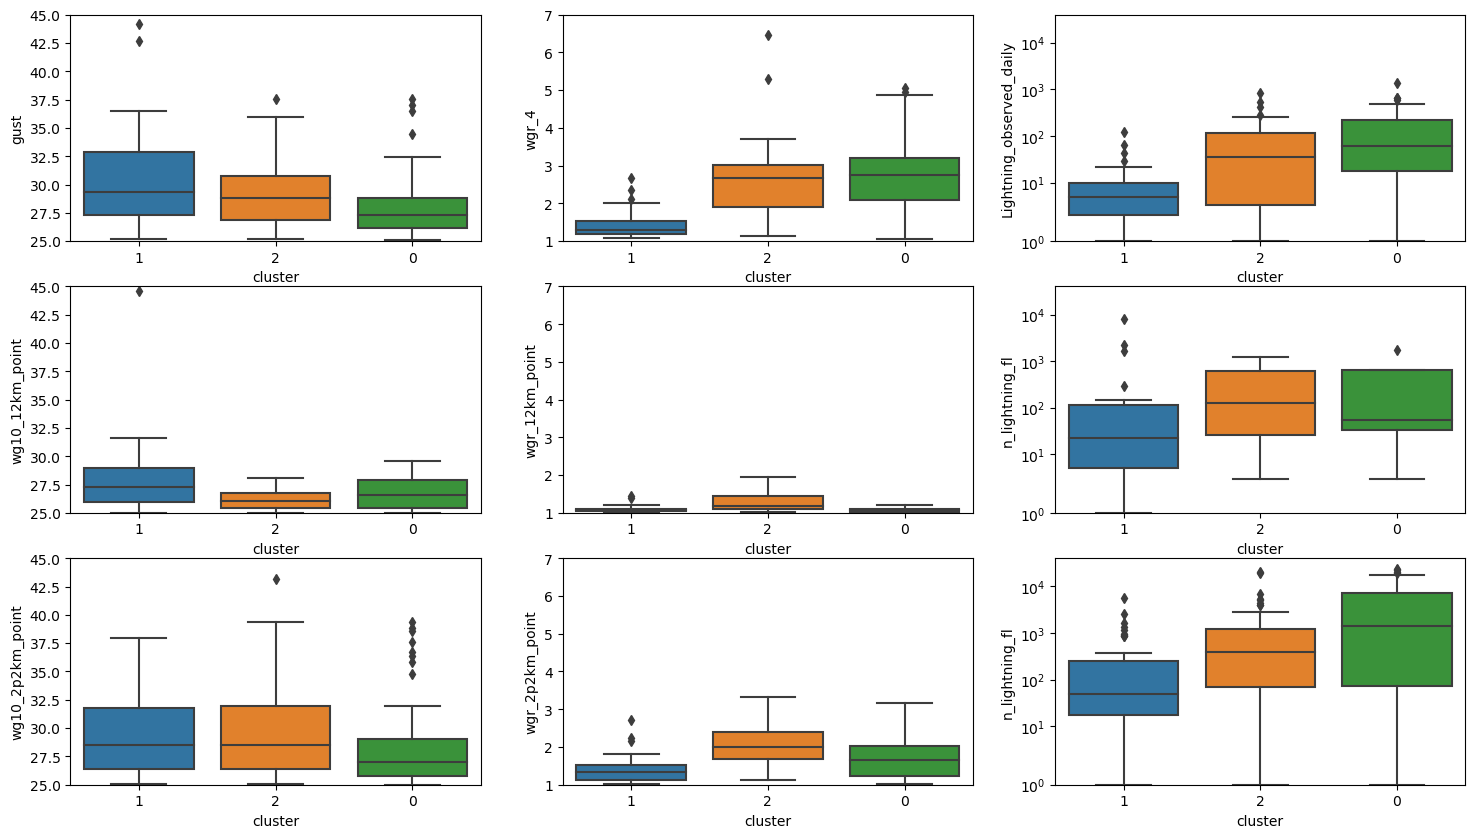

In [14]:
#For severe convective (with lightning) daily-domain maximum gusts (+25 m/s), look at the difference in gust speed, wgr, and lightning between clusters. For each BARPA model, and observations

plt.figure(figsize=[18,10])
plt.subplot(3,3,1); sns.boxplot(data=dmax_obs_conv.query("(Lightning_observed_daily>=1) & (gust>=25)"),x="cluster",y="gust",order=[1,2,0]); plt.ylim([25,45])
plt.subplot(3,3,2); sns.boxplot(data=dmax_obs_conv.query("(Lightning_observed_daily>=1) & (gust>=25)"),x="cluster",y="wgr_4",order=[1,2,0]); plt.ylim([1,7])
plt.subplot(3,3,3); sns.boxplot(data=dmax_obs_conv.query("(Lightning_observed_daily>=1) & (gust>=25)"),x="cluster",y="Lightning_observed_daily",order=[1,2,0]); plt.yscale("symlog"); plt.ylim([1,40000])

plt.subplot(3,3,4); sns.boxplot(data=dmax_12km_conv.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)"),x="cluster",y="wg10_12km_point",order=[1,2,0]); plt.ylim([25,45])
plt.subplot(3,3,5); sns.boxplot(data=dmax_12km_conv.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)"),x="cluster",y="wgr_12km_point",order=[1,2,0]); plt.ylim([1,7])
plt.subplot(3,3,6); sns.boxplot(data=dmax_12km_conv.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)"),x="cluster",y="n_lightning_fl",order=[1,2,0]); plt.yscale("symlog"); plt.ylim([1,40000])

plt.subplot(3,3,7); sns.boxplot(data=dmax_2p2km_conv.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)"),x="cluster",y="wg10_2p2km_point",order=[1,2,0]); plt.ylim([25,45])
plt.subplot(3,3,8); sns.boxplot(data=dmax_2p2km_conv.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)"),x="cluster",y="wgr_2p2km_point",order=[1,2,0]); plt.ylim([1,7])
plt.subplot(3,3,9); sns.boxplot(data=dmax_2p2km_conv.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)"),x="cluster",y="n_lightning_fl",order=[1,2,0]); plt.yscale("symlog"); plt.ylim([1,40000])

(0.0, 100000.0)

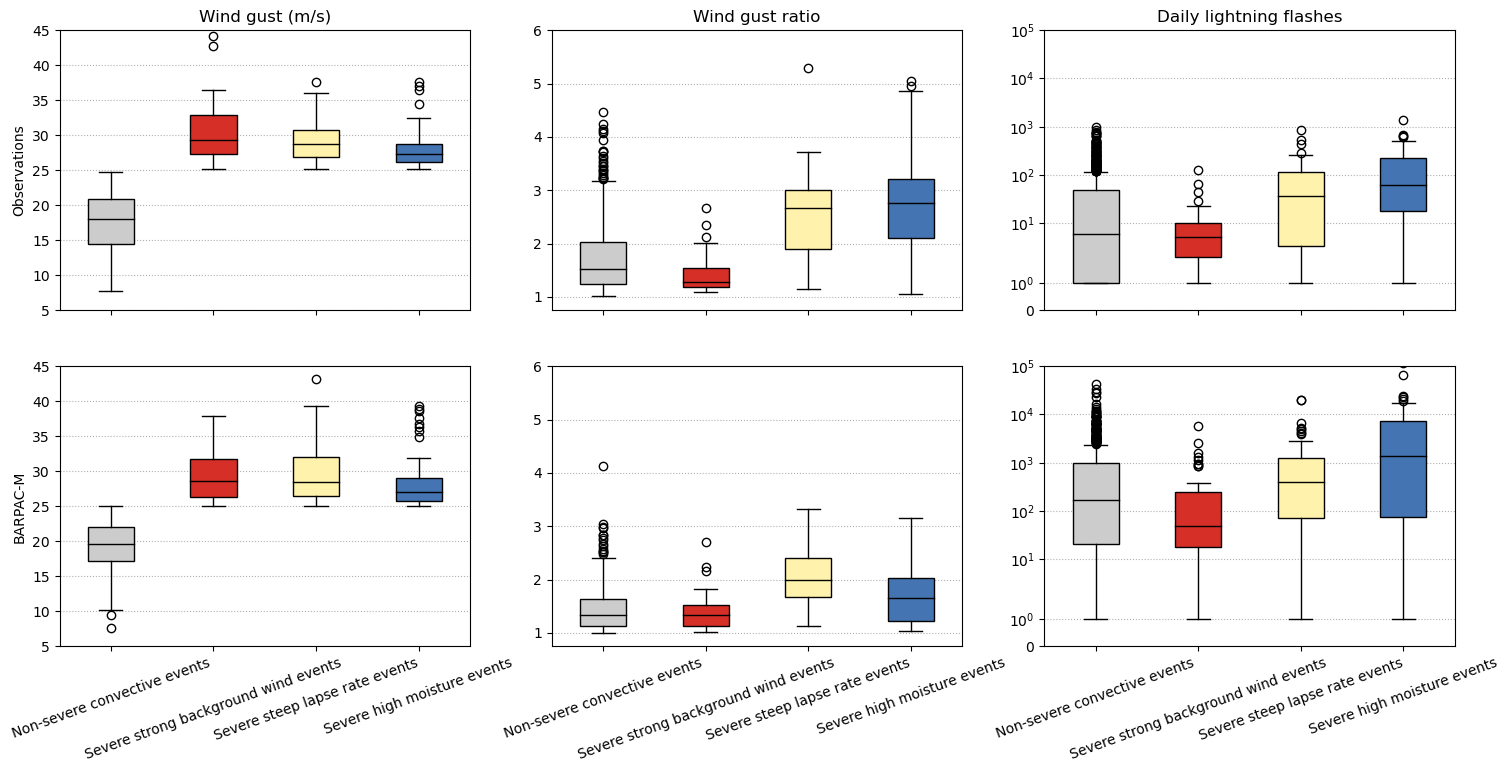

In [61]:
#Same as the above plot, but also considering non-severe domain-daily max gusts as a separate box

def plot_box(df_conv,v,gust_col,xticks=False):
    rgb = [[0.8,0.8,0.8]]
    p=rgb + [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    
    
    b = plt.gca().boxplot([df_conv[df_conv[gust_col]<25][v],
                  df_conv[df_conv[gust_col]>=25].query("(cluster==1)")[v],
                  df_conv[df_conv[gust_col]>=25].query("(cluster==2)")[v],
                  df_conv[df_conv[gust_col]>=25].query("(cluster==0)")[v]],patch_artist=True);

    for patch, color in zip(b["boxes"], p):
        patch.set(facecolor=color)
    [patch.set(color="k") for patch in b["medians"]]
    
    plt.gca().grid(axis="y",ls=":")
    
    if xticks:
        plt.xticks([1,2,3,4],["Non-severe convective events","Severe strong background wind events","Severe steep lapse rate events","Severe high moisture events"])
        plt.gca().tick_params("x",rotation=20)
    else:
        plt.xticks([1,2,3,4],["","","",""])


plt.figure(figsize=[18,8])
plt.subplot(2,3,1); plot_box(dmax_obs_conv,"gust","gust");plt.ylim([5,45]); plt.title("Wind gust (m/s)"); plt.ylabel("Observations")
plt.subplot(2,3,2); plot_box(dmax_obs_conv,"wgr_4","gust");plt.ylim([0.75,6]); plt.title("Wind gust ratio")
plt.subplot(2,3,3); plot_box(dmax_obs_conv,"Lightning_observed_daily","gust"); plt.yscale("symlog"); plt.ylim([0,1e5]); plt.title("Daily lightning flashes")

# plt.subplot(3,3,4); plot_box(dmax_12km_conv,"wg10_12km_point","wg10_12km_point");plt.ylim([5,45])
# plt.subplot(3,3,5); plot_box(dmax_12km_conv,"wgr_12km_point","wg10_12km_point");plt.ylim([1,6])
# plt.subplot(3,3,6); plot_box(dmax_12km_conv,"n_lightning_fl","wg10_12km_point"); plt.yscale("symlog"); plt.ylim([0,1e5])

plt.subplot(2,3,4); plot_box(dmax_2p2km_conv,"wg10_2p2km_point","wg10_2p2km_point",xticks=True);plt.ylim([5,45]); plt.ylabel("BARPAC-M")
plt.subplot(2,3,5); plot_box(dmax_2p2km_conv,"wgr_2p2km_point","wg10_2p2km_point",xticks=True);plt.ylim([0.75,6])
plt.subplot(2,3,6); plot_box(dmax_2p2km_conv,"n_lightning_fl","wg10_2p2km_point",xticks=True); plt.yscale("symlog"); plt.ylim([0,1e5])




Text(0, 0.5, 'Gust speed (m/s)')

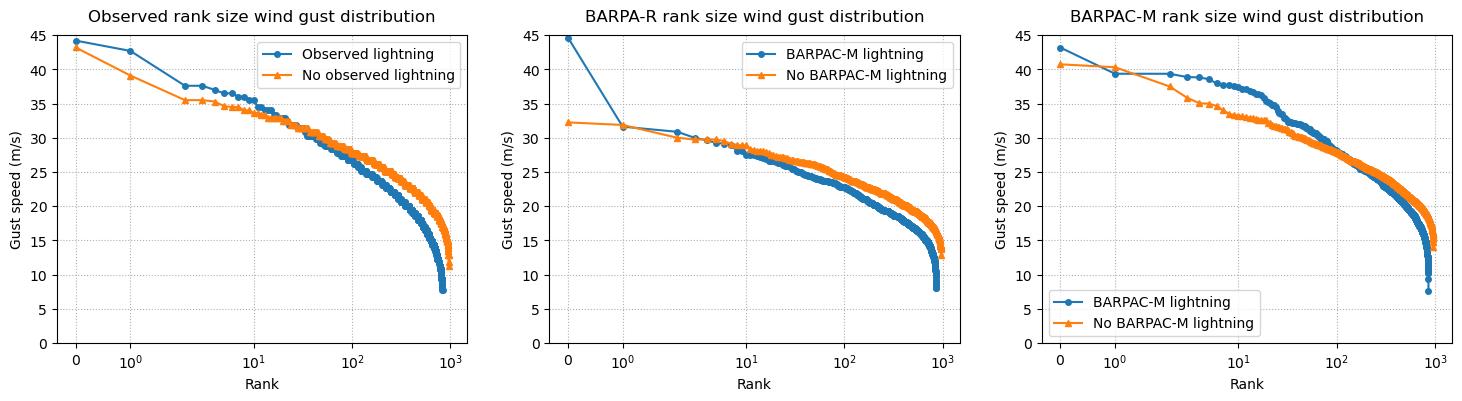

In [21]:
plt.figure(figsize=[18,4])
plt.subplot(1,3,1)

plt.plot(np.flip(np.sort(dmax_obs_conv.gust)),
                 label="Observed lightning",color="tab:blue",marker="o",ms=4)
plt.plot(np.flip(np.sort(dmax_obs_nonconv.gust)),
                 label="No observed lightning",color="tab:orange",marker="^",ms=4)
plt.xscale("symlog")
plt.ylim([0,45])
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("Rank")
plt.title("Observed rank size wind gust distribution",pad=10)
plt.ylabel("Gust speed (m/s)")



plt.subplot(1,3,2)

plt.plot(np.flip(np.sort(dmax_12km_conv.wg10_12km_point)),
                 label="BARPAC-M lightning",color="tab:blue",marker="o",ms=4)
plt.plot(np.flip(np.sort(dmax_12km_nonconv.wg10_12km_point)),
                 label="No BARPAC-M lightning",color="tab:orange",marker="^",ms=4)
plt.xscale("symlog")
plt.ylim([0,45])
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("Rank")
plt.title("BARPA-R rank size wind gust distribution",pad=10)
plt.ylabel("Gust speed (m/s)")



plt.subplot(1,3,3)

plt.plot(np.flip(np.sort(dmax_2p2km_conv.wg10_2p2km_point)),
                 label="BARPAC-M lightning",color="tab:blue",marker="o",ms=4)
plt.plot(np.flip(np.sort(dmax_2p2km_nonconv.wg10_2p2km_point)),
                 label="No BARPAC-M lightning",color="tab:orange",marker="^",ms=4)
plt.xscale("symlog")
plt.ylim([0,45])
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("Rank")
plt.title("BARPAC-M rank size wind gust distribution",pad=10)
plt.ylabel("Gust speed (m/s)")



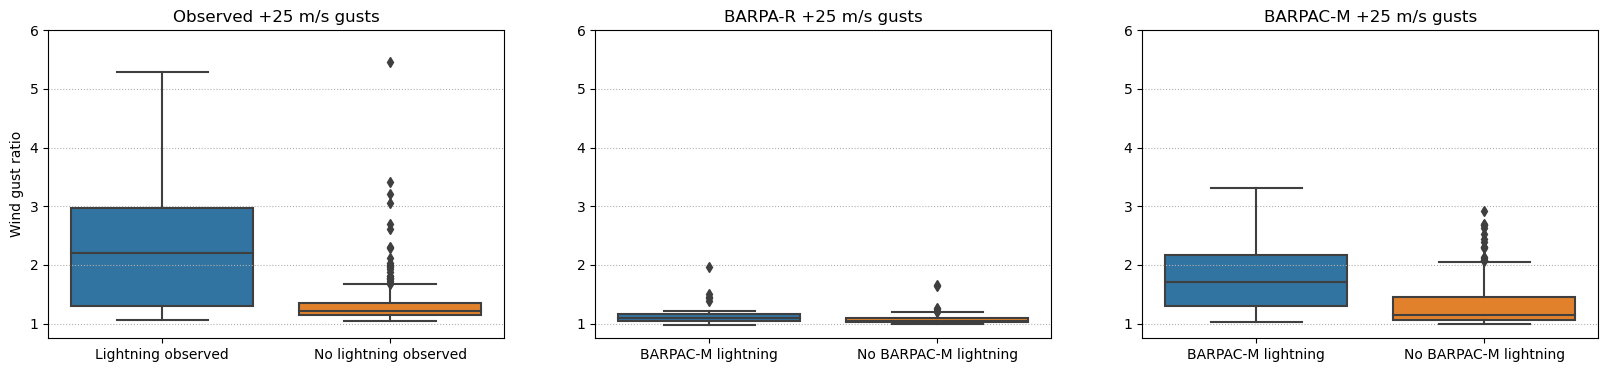

In [47]:
plt.figure(figsize=[20,4])

plt.subplot(1,3,1)

sns.boxplot(
    [dmax_obs_conv.query("(gust>=25)").wgr_4,
    dmax_obs_nonconv.query("(gust>=25)").wgr_4])
plt.ylim([0.75,6])
plt.xticks([0,1],["Lightning observed","No lightning observed"])
plt.title("Observed +25 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Wind gust ratio")

plt.subplot(1,3,2)

sns.boxplot(
    [dmax_12km_conv.query("(wg10_12km_point>=25)").wgr_12km_point,
    dmax_12km_nonconv.query("(wg10_12km_point>=25)").wgr_12km_point])
plt.ylim([0.75,6])
plt.xticks([0,1],["BARPAC-M lightning","No BARPAC-M lightning"])
plt.title("BARPA-R +25 m/s gusts")
plt.gca().grid(axis="y",ls=":")

plt.subplot(1,3,3)

sns.boxplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").wgr_2p2km_point,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=25)").wgr_2p2km_point])
plt.ylim([0.75,6])
plt.xticks([0,1],["BARPAC-M lightning","No BARPAC-M lightning"])
plt.title("BARPAC-M +25 m/s gusts")
plt.gca().grid(axis="y",ls=":")

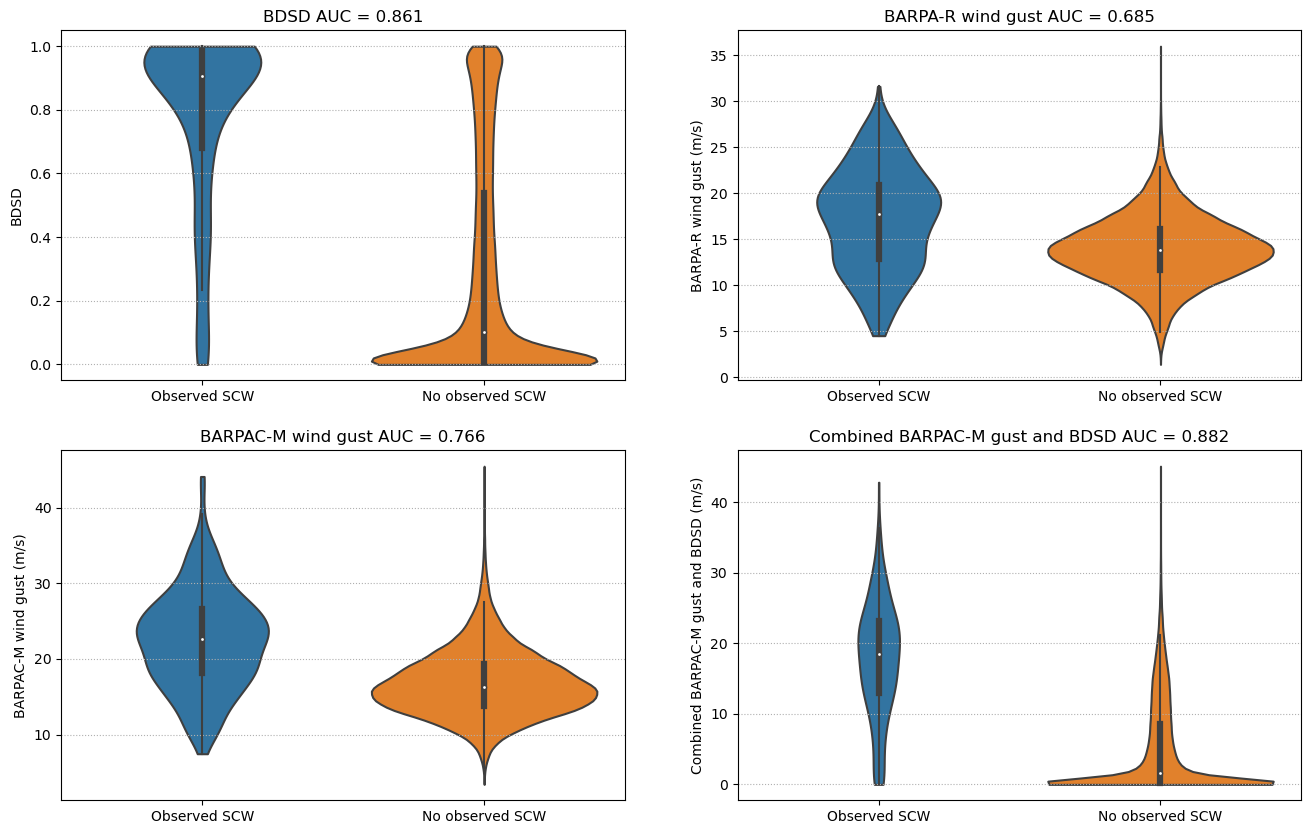

In [24]:
plt.figure(figsize=[16,10])
plt.subplot(2,2,1)
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").bdsd,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").bdsd],cut=0)
plt.title("BDSD AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["bdsd"]),3)))
plt.ylabel("BDSD")
plt.xticks([0,1],["Observed SCW","No observed SCW"])
plt.gca().grid(axis="y",ls=":")

plt.subplot(2,2,2)
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").wg10_12km_rad,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").wg10_12km_rad],cut=0)
plt.title("BARPA-R wind gust AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["wg10_12km_rad"]),3)))
plt.ylabel("BARPA-R wind gust (m/s)")
plt.xticks([0,1],["Observed SCW","No observed SCW"])
plt.gca().grid(axis="y",ls=":")

plt.subplot(2,2,3)
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").wg10_2p2km_rad,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").wg10_2p2km_rad],cut=0)
plt.title("BARPAC-M wind gust AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["wg10_2p2km_rad"]),3)))
plt.ylabel("BARPAC-M wind gust (m/s)")
plt.xticks([0,1],["Observed SCW","No observed SCW"])
plt.gca().grid(axis="y",ls=":")

plt.subplot(2,2,4)
dmax_obs["combo"] = dmax_obs["bdsd"] * dmax_obs["wg10_2p2km_rad"]
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").combo,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").combo],cut=0)
plt.title("Combined BARPAC-M gust and BDSD AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["combo"]),3)))
plt.ylabel("Combined BARPAC-M gust and BDSD (m/s)")
plt.xticks([0,1],["Observed SCW","No observed SCW"]);
plt.gca().grid(axis="y",ls=":");

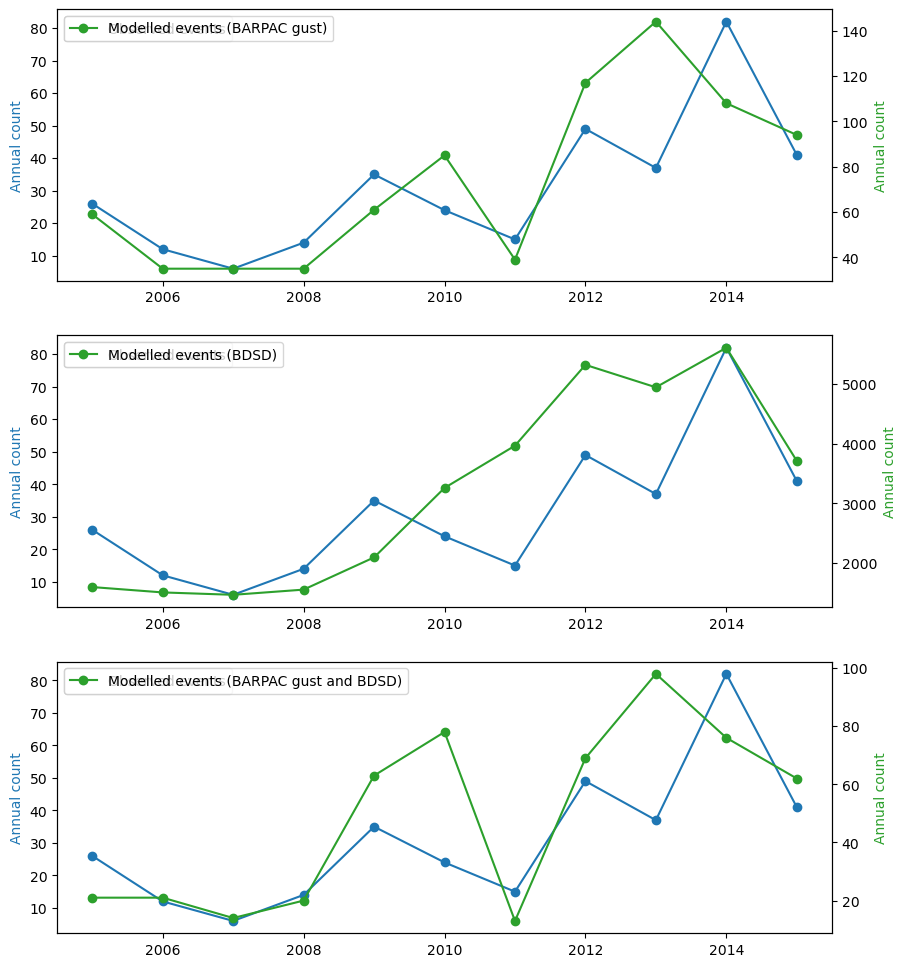

In [97]:
plt.figure(figsize=[10,12])

plt.subplot(3,1,1)
dmax_obs.query("(gust>=25) & (Lightning_observed_daily>=1)").index.year.value_counts().sort_index().plot(marker="o",label="Observed events")
plt.ylabel("Annual count",color="tab:blue")
plt.legend()
ax2=plt.gca().twinx()
dmax_2p2km_point.query("(wg10_2p2km_point>=25) & (n_lightning_fl>=1)").index.year.value_counts().sort_index().plot(marker="o",color="tab:green",ax=ax2,
                                                                                                                    label="Modelled events (BARPAC gust)")
plt.ylabel("Annual count",color="tab:green")
plt.legend()

plt.subplot(3,1,3)
dmax_obs.query("(gust>=25) & (Lightning_observed_daily>=1)").index.year.value_counts().sort_index().plot(marker="o",label="Observed events")
plt.ylabel("Annual count",color="tab:blue")
plt.legend()
ax2=plt.gca().twinx()
dmax_2p2km_point["combo"] = dmax_2p2km_point["wg10_2p2km_point"] * dmax_2p2km_point["bdsd"]
dmax_2p2km_point.query("(combo>=25)").index.year.value_counts().sort_index().plot(marker="o",color="tab:green",ax=ax2,
                                                                                    label="Modelled events (BARPAC gust and BDSD)")
plt.legend()
plt.ylabel("Annual count",color="tab:green")

plt.subplot(3,1,2)
dmax_obs.query("(gust>=25) & (Lightning_observed_daily>=1)").index.year.value_counts().sort_index().plot(marker="o",label="Observed events")
plt.ylabel("Annual count",color="tab:blue")
plt.legend()
ax2=plt.gca().twinx()
dmax_bdsd.query("(bdsd>=0.83)").index.year.value_counts().sort_index().plot(marker="o",color="tab:green",ax=ax2,
                                                                           label="Modelled events (BDSD)")
plt.ylabel("Annual count",color="tab:green")
plt.legend()

In [26]:
obs_ann_counts = dmax_obs.query("(gust>=25) & (Lightning_observed_daily>=1)").index.year.value_counts().sort_index().values
gust_ann_counts = dmax_2p2km_point.query("(wg10_2p2km_point>=25) & (n_lightning_fl>=1)").index.year.value_counts().sort_index().values
combo_ann_counts = dmax_2p2km_point.query("(combo>=25)").index.year.value_counts().sort_index().values
bdsd_ann_counts = dmax_bdsd.query("(bdsd>=0.83)").index.year.value_counts().sort_index().values

print("BARPAC gust: ",spearmanr(obs_ann_counts, gust_ann_counts))
print("BDSD: ",spearmanr(obs_ann_counts, bdsd_ann_counts))
print("Combined: ",spearmanr(obs_ann_counts, combo_ann_counts))


BARPAC gust:  SignificanceResult(statistic=0.8991204081865278, pvalue=0.0001661839752544972)
BDSD:  SignificanceResult(statistic=0.8636363636363636, pvalue=0.0006116938500931706)
Combined:  SignificanceResult(statistic=0.6833730713673077, pvalue=0.02043986029912546)


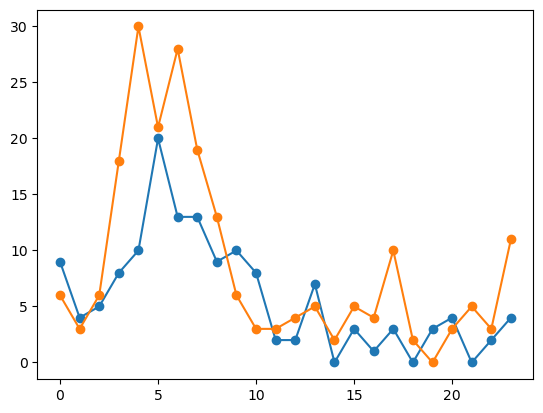

In [70]:
plt.plot(np.arange(0,24),[(pd.to_datetime(dmax_obs_conv.query("(gust>=25)").time).dt.hour == h).sum() for h in np.arange(0,24)],marker="o")
plt.plot(np.arange(0,24),[(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").time).dt.hour == h).sum() for h in np.arange(0,24)],marker="o")

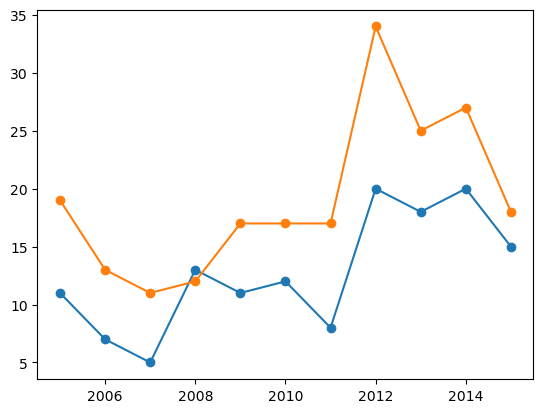

In [71]:
plt.plot(np.arange(2005,2016),[(pd.to_datetime(dmax_obs_conv.query("(gust>=25)").time).dt.year == h).sum() for h in np.arange(2005,2016)],marker="o")
plt.plot(np.arange(2005,2016),[(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").time).dt.year == h).sum() for h in np.arange(2005,2016)],marker="o")

In [66]:
spearmanr(
    [(pd.to_datetime(dmax_obs_conv.query("(gust>=25)").time).dt.year == h).sum() for h in np.arange(2005,2016)],
    [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").time).dt.year == h).sum() for h in np.arange(2005,2016)])

SignificanceResult(statistic=0.7926351445067078, pvalue=0.0036185978004378994)